In [32]:
import sys
import pandas as pd
from datatransformer import DataTransformerDeep
sys.path.insert(0, 'C:/Udvikler/Speciale/SpecialeKode')
from utils import *
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # For boxplot legend entries
import matplotlib.lines as mlines  # For axhline legend entry
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
#Configs 

sample_methods = [
    "time_biased"
]

alphas = [
          "0.75"
        ]


all_features = [
    ["bpv_risk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid", "FirmAccount", "Price_Diff"],
    ["bpv_risk", "delta_h_t", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid", "FirmAccount", "Price_Diff"],
    ["inventoryRisk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid", "FirmAccount", "Price_Diff"],
    ["inventoryRisk", "delta_h_t", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid", "FirmAccount", "Price_Diff"],    
]

all_reward_functions = [
    risk_PnL_reward,
    inventory_PnL_reward,
    hitrate_target_reward,
    linearMarginReward,
    quadraticMarginReward
]

learning_algorithms = [
    'random_by_action_distr',
    'random_by_uniform',
    'CQL'
]

metrics = ["dealerHitRate", "mlHitRate", "MLWinShare", "mlDistToCoverMean", "mlDistToCoverStd", "dealerDistToCoverMean", 
           "meanMLProfit", "meanDealerProfit", "meanRLReward", "dealerD2TargetMean", "MLD2TargetMean", "MLD2TargetStd",
           "meanMLSharpeRatio", "meanDealerSharpeRatio", "meanDealerSharpeRatioNoNeg", "DealerNetInventoryDiff", "MLNetInventoryDiff"]


all_features_str = [",".join(features) for features in all_features]  

# Create a MultiIndex for the DataFrame using the combinations of parameters
index = pd.MultiIndex.from_tuples(
    [(features, reward_function.__name__, learning_algorithm, sample_method, alpha)
     for features, reward_function, learning_algorithm, sample_method, alpha in 
     itertools.product(all_features_str, all_reward_functions, learning_algorithms, sample_methods, alphas)
     if (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
         ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward") and
         (("delta_h_t" in features and reward_function.__name__ == "hitrate_target_reward") or
             ("delta_h_t" not in features and reward_function.__name__ != "hitrate_target_reward")))],
    names=["Features", "Reward Function", "Learning Algorithm", "Sample method", "Alpha"]
)

In [ ]:
all_results = []

for idx in index:

    
    file_path = f"experiments_results/results_{idx[0]}_{idx[1]}_{idx[2]}_{idx[3]}_{idx[4]}.csv"
  
    if not os.path.exists(file_path):
        print(f"Warning: Results file not found for {idx}. Skipping.")
        continue  # Skip missing file
    
    trial_data = pd.read_csv(file_path)  

    # Extract relevant parts of the key
    features_key = idx[0].split(",")[0]  # Get the first feature from the feature list
    reward_function_key = idx[1]         
    algorithm_key = idx[2]               
    
    features = idx[0].split(",")
    if "delta_h_t" in features:
        features_key += "_delta_h_t"
    
    # Create a simplified combination label
    if algorithm_key in ['random_by_action_distr', 'random_by_uniform']:
        simplified_key = algorithm_key
    else:
        simplified_key = f"{features_key}_{reward_function_key}_{algorithm_key}"

    trial_data['Combination'] = simplified_key  
    all_results.append(trial_data)
    
all_results_df = pd.concat(all_results, ignore_index=True)

all_results_df['Combination'].unique()

array(['random_by_action_distr', 'random_by_uniform',
       'bpv_risk_risk_PnL_reward_CQL', 'bpv_risk_linearMarginReward_CQL',
       'bpv_risk_quadraticMarginReward_CQL',
       'bpv_risk_delta_h_t_hitrate_target_reward_CQL',
       'inventoryRisk_inventory_PnL_reward_CQL',
       'inventoryRisk_linearMarginReward_CQL',
       'inventoryRisk_quadraticMarginReward_CQL',
       'inventoryRisk_delta_h_t_hitrate_target_reward_CQL'], dtype=object)

In [35]:
print(index)
all_results_df['Combination'].unique()

MultiIndex([(               'bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', ...),
            (               'bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', ...),
            (               'bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', ...),
            (               'bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', ...),
            (               'bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', ...),
            (               'bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', ...),
            (               'bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', ...),
            (               'bpv_risk,Duration,Amount,Side,DealersInCompetit

array(['random_by_action_distr', 'random_by_uniform',
       'bpv_risk_risk_PnL_reward_CQL', 'bpv_risk_linearMarginReward_CQL',
       'bpv_risk_quadraticMarginReward_CQL',
       'bpv_risk_delta_h_t_hitrate_target_reward_CQL',
       'inventoryRisk_inventory_PnL_reward_CQL',
       'inventoryRisk_linearMarginReward_CQL',
       'inventoryRisk_quadraticMarginReward_CQL',
       'inventoryRisk_delta_h_t_hitrate_target_reward_CQL'], dtype=object)

In [ ]:
all_results_df['ML_delta_hitrate'] = abs(all_results_df['mlHitRate'] - 24.19)
all_results_df['Dealer_delta_hitrate'] = abs(all_results_df['dealerHitRate'] - 24.19)

all_results_df['MLSharpeRatioNorm'] = all_results_df['meanMLSharpeRatio'] * (1-all_results_df['ML_delta_hitrate']/100)
all_results_df['DealerSharpeRatioNorm'] = all_results_df['meanDealerSharpeRatio'] * (1-all_results_df['Dealer_delta_hitrate']/100)



all_results_df['MLSharpeRatioSquared'] = (all_results_df['MLSharpeRatioHitrate']*(all_results_df['meanMLProfit']))/10000 
all_results_df['DealerSharpeRatioSquared'] = (all_results_df['DealerSharpeRatioHitrate']*(all_results_df['meanDealerProfit']))/10000 


all_results_df["meanDealerProfit"] = all_results_df["meanDealerProfit"]*10 
all_results_df["meanMLProfit"] = all_results_df["meanMLProfit"]*10 


l=0.3

all_results_df['MLSharpeRatioSub'] = (all_results_df['MLSharpeRatioHitrate']*all_results_df['meanMLProfit'])/10000 \
                                                - l*all_results_df['ML_delta_hitrate']

all_results_df['DealerSharpeRatioSub'] = (all_results_df['DealerSharpeRatioHitrate']*all_results_df['meanDealerProfit'])/10000 \
                                                    - l*all_results_df['Dealer_delta_hitrate']
                                


In [37]:
all_results_df

,Unnamed: 0,dealerHitRate,mlHitRate,MLWinShare,mlDistToCoverMean,mlDistToCoverStd,dealerDistToCoverMean,meanMLProfit,meanDealerProfit,meanRLReward,...,MLNetInventoryDiff,Combination,ML_delta_hitrate,Dealer_delta_hitrate,MLSharpeRatioNorm,DealerSharpeRatioNorm,MLSharpeRatioSquared,DealerSharpeRatioSquared,MLSharpeRatioSub,DealerSharpeRatioSub
0,0,24.36,28.91,17.124229,1.73,1.684338,1.4,205.0,724.0,0.976380,...,7.718979e+08,random_by_action_distr,4.72,0.17,0.171504,0.079864,0.704318,1.213858,5.627185,12.087584
1,1,24.36,31.68,23.867694,1.74,1.905014,1.4,217.0,724.0,0.975780,...,5.035818e+08,random_by_action_distr,7.49,0.17,0.175769,0.079864,0.719246,1.213858,4.945465,12.087584
2,2,24.36,28.51,21.572183,1.69,1.747311,1.4,356.0,724.0,0.975892,...,7.194796e+08,random_by_action_distr,4.32,0.17,0.181792,0.079864,1.353120,1.213858,12.235204,12.087584
3,3,24.36,25.94,24.031068,1.98,1.704718,1.4,316.0,724.0,0.972208,...,-1.405195e+08,random_by_action_distr,1.75,0.17,0.167025,0.079864,1.082332,1.213858,10.298316,12.087584
4,4,24.36,27.92,26.063537,1.84,1.936158,1.4,471.0,724.0,0.976694,...,6.155309e+08,random_by_action_distr,3.73,0.17,0.134778,0.079864,1.215321,1.213858,11.034213,12.087584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,15,24.36,43.17,43.690453,1.49,1.736799,1.4,516.0,724.0,0.989840,...,-3.889276e+08,inventoryRisk_delta_h_t_hitrate_target_reward_CQL,18.98,0.17,0.137734,0.079864,1.359712,1.213858,7.903116,12.087584
196,16,24.36,42.38,50.274945,1.49,1.786854,1.4,513.0,724.0,0.989491,...,-9.272396e+08,inventoryRisk_delta_h_t_hitrate_target_reward_CQL,18.19,0.17,0.130896,0.079864,1.359193,1.213858,8.134935,12.087584
197,17,24.36,41.58,49.528982,1.51,1.799829,1.4,484.0,724.0,0.989774,...,-1.182125e+09,inventoryRisk_delta_h_t_hitrate_target_reward_CQL,17.39,0.17,0.223047,0.079864,2.236274,1.213858,17.145736,12.087584
198,18,24.36,42.18,45.157334,1.56,1.786510,1.4,619.0,724.0,0.989044,...,-3.695164e+08,inventoryRisk_delta_h_t_hitrate_target_reward_CQL,17.99,0.17,0.155819,0.079864,1.902311,1.213858,13.626108,12.087584


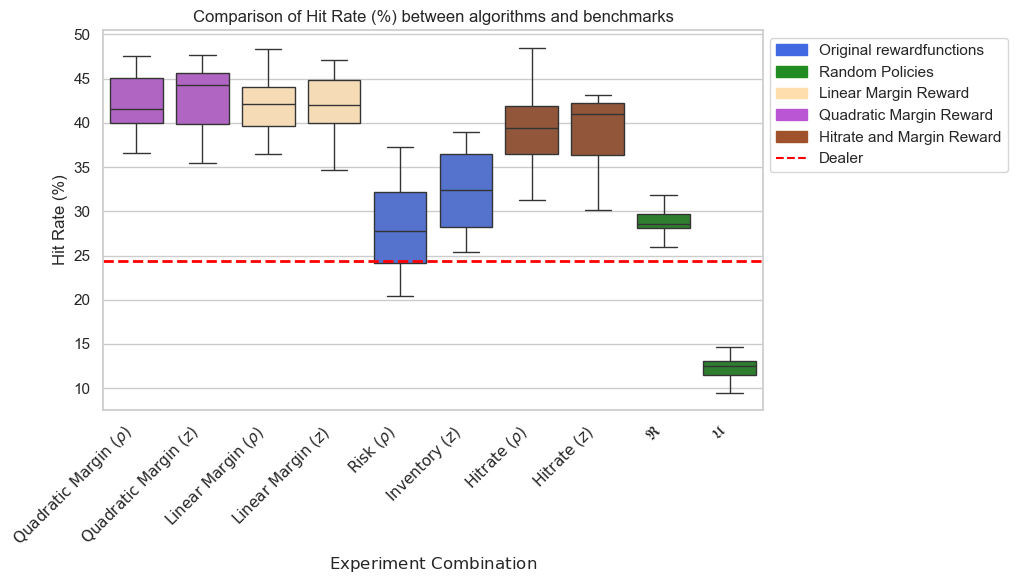

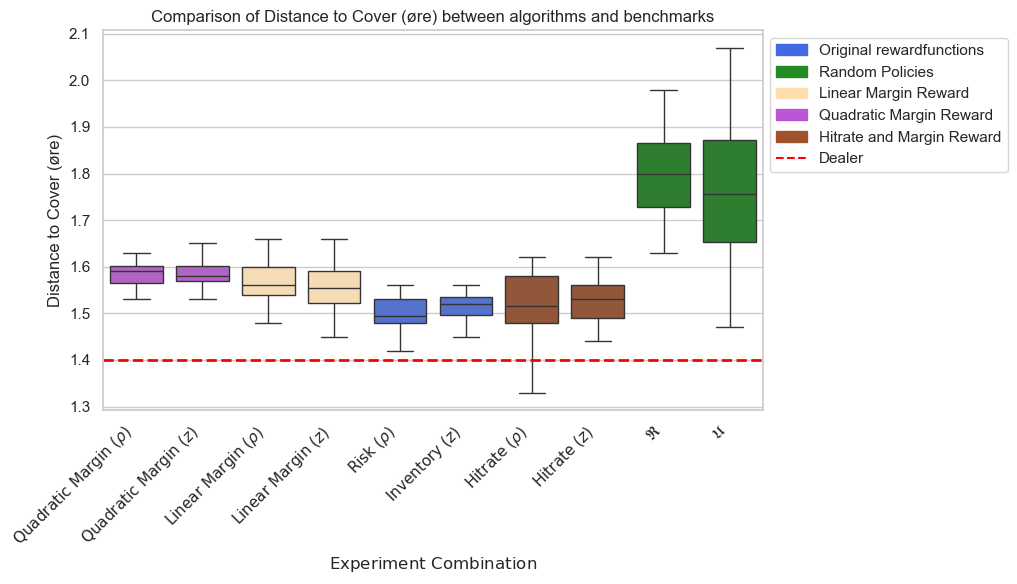

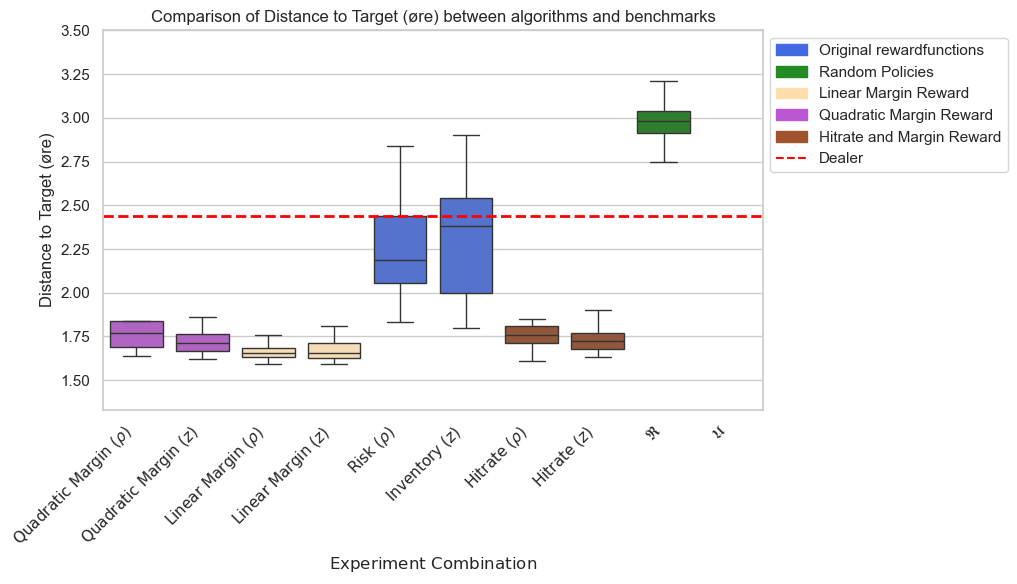

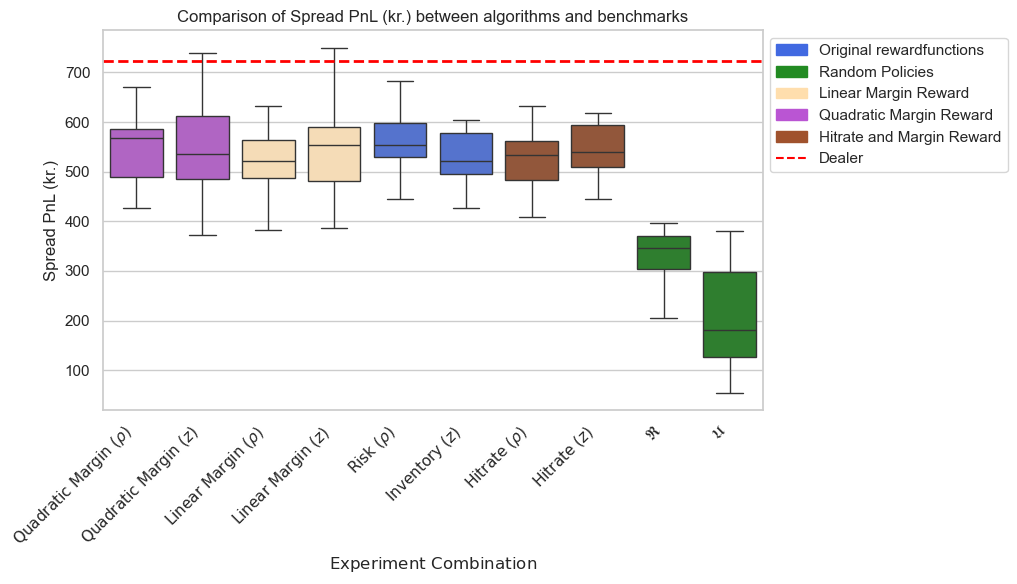

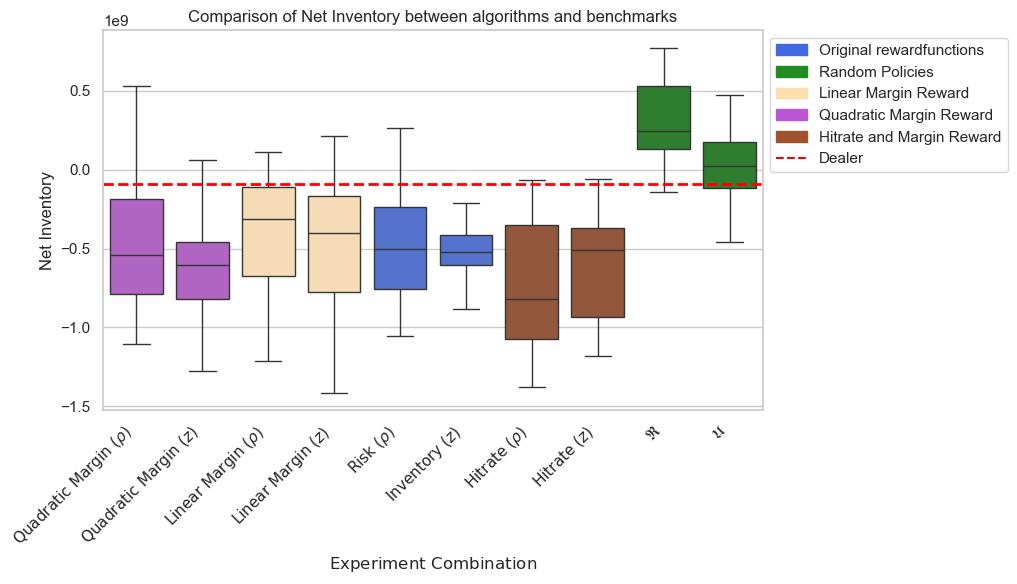

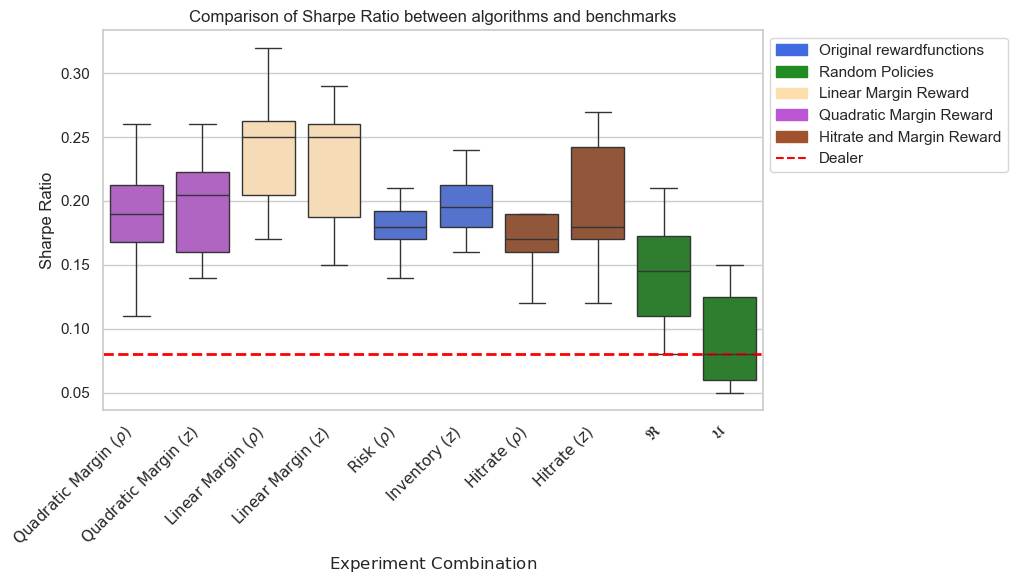

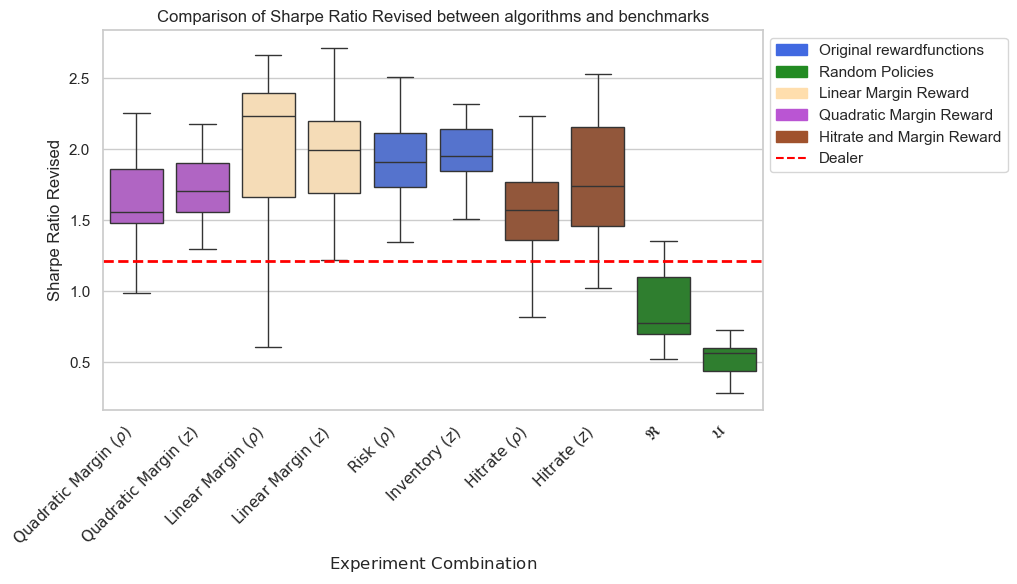

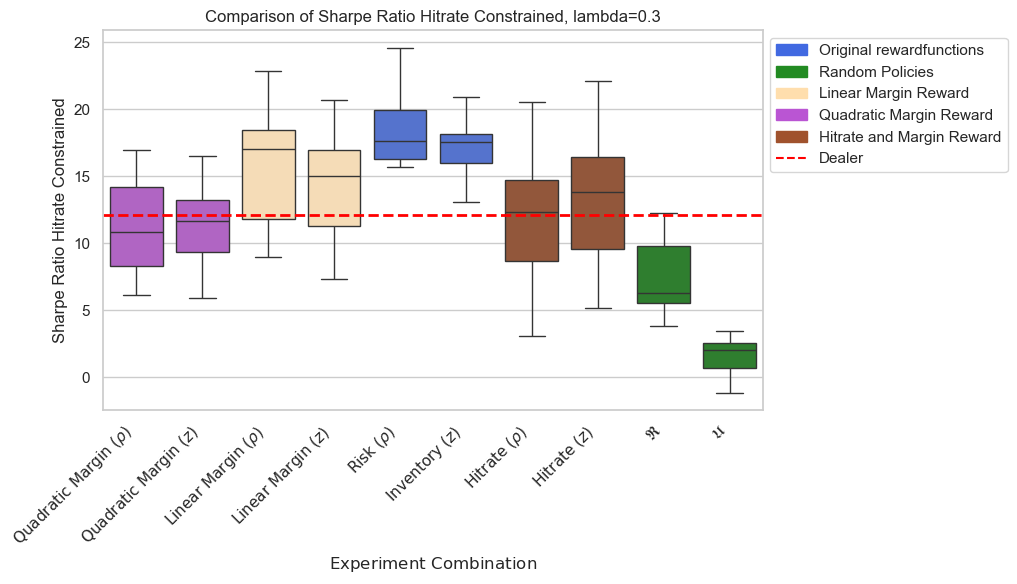

In [38]:
# Map LaTeX-style labels
combination_labels = {
    "bpv_risk_risk_PnL_reward_CQL": r"$\mathrm{Risk} \ (\rho)$",
    "bpv_risk_linearMarginReward_CQL": r"$\rho\ (\mathrm{Linear\ Margin})$",
    "bpv_risk_quadraticMarginReward_CQL": r"$\rho\ (\mathrm{Quadratic\ Margin})$",
    "bpv_risk_delta_h_t_hitrate_target_reward_CQL": r"$\rho\ (\mathrm{Hitrate})$",
    "inventoryRisk_inventory_PnL_reward_CQL": r"$z\ (\mathrm{Inventory})$",
    "inventoryRisk_linearMarginReward_CQL": r"$z\ (\mathrm{Linear\ Margin})$",
    "inventoryRisk_quadraticMarginReward_CQL": r"$z\ (\mathrm{Quadratic\ Margin})$",
    "inventoryRisk_delta_h_t_hitrate_target_reward_CQL": r"$z\ (\mathrm{Hitrate})$",
    "random_by_action_distr": r"$\mathfrak{R}$",
    "random_by_uniform": r"$\mathfrak{U}$"
}

combination_labels = {
    "bpv_risk_risk_PnL_reward_CQL": r"$\mathrm{Risk}\ (\rho)$",
    "bpv_risk_linearMarginReward_CQL": r"$\mathrm{Linear\ Margin}\ (\rho)$",
    "bpv_risk_quadraticMarginReward_CQL": r"$\mathrm{Quadratic\ Margin}\ (\rho)$",
    "bpv_risk_delta_h_t_hitrate_target_reward_CQL": r"$\mathrm{Hitrate}\ (\rho)$",
    "inventoryRisk_inventory_PnL_reward_CQL": r"$\mathrm{Inventory}\ (z)$",
    "inventoryRisk_linearMarginReward_CQL": r"$\mathrm{Linear\ Margin}\ (z)$",
    "inventoryRisk_quadraticMarginReward_CQL": r"$\mathrm{Quadratic\ Margin}\ (z)$",
    "inventoryRisk_delta_h_t_hitrate_target_reward_CQL": r"$\mathrm{Hitrate}\ (z)$",
    "random_by_action_distr": r"$\mathfrak{R}$",
    "random_by_uniform": r"$\mathfrak{U}$"
}

# Separate metrics into ML and Dealer pairs
metrics_boxplot = [
    ("dealerHitRate", "mlHitRate", "Hit Rate (%)"), 
    ("dealerDistToCoverMean", "mlDistToCoverMean", "Distance to Cover (øre)"),
    ("dealerD2TargetMean", "MLD2TargetMean", "Distance to Target (øre)"),
    ("meanDealerProfit", "meanMLProfit", "Spread PnL (kr.)" ),
    ("DealerNetInventoryDiff", "MLNetInventoryDiff", "Net Inventory"),
    ("meanDealerSharpeRatio", "meanMLSharpeRatio", "Sharpe Ratio"),
    ("DealerSharpeRatioSquared", "MLSharpeRatioSquared", "Sharpe Ratio Revised"),
    ("DealerSharpeRatioSub", "MLSharpeRatioSub", "Sharpe Ratio Hitrate Constrained"),
    
]

sns.set_theme(style="whitegrid")

# Add a column for LaTeX labels
all_results_df["Combination_Label"] = all_results_df["Combination"].map(combination_labels)

# Define custom colors
reward_colors = {'linearMarginReward': 'navajowhite', 'quadraticMarginReward': 'mediumorchid', 'hitrate_target_reward': 'sienna'}
default_color = 'royalblue'  # Default boxplot color for DQN configurations
random_color = 'forestgreen'  # Color for random policies

# Define colors based on original keys
palette = {}
for combination in all_results_df['Combination'].unique():
    if 'random_by_action_distr' in combination or 'random_by_uniform' in combination:
        palette[combination] = random_color
    elif 'linearMarginReward' in combination:
        palette[combination] = reward_colors['linearMarginReward']
    elif 'quadraticMarginReward' in combination:
        palette[combination] = reward_colors['quadraticMarginReward']
    elif 'hitrate_target_reward' in combination:
        palette[combination] = reward_colors['hitrate_target_reward']
    else:
        palette[combination] = default_color

# Maintain order based on logic
ordered_combinations = sorted(
    palette.keys(), 
    key=lambda x: (palette[x], x)
)

# Separate random policies and ensure they are plotted last
random_policies = [key for key in ordered_combinations if 'random_by_action_distr' in key or 'random_by_uniform' in key]
non_random_policies = [key for key in ordered_combinations if key not in random_policies]
ordered_combinations = non_random_policies + random_policies

# Map LaTeX labels to original order
ordered_labels = [combination_labels[key] for key in ordered_combinations]



def boxplot_results(dealer_metric, ml_metric, y_label):

            sns.boxplot(
                data=all_results_df, 
                x="Combination_Label",  # Use LaTeX labels for x-axis
                y=ml_metric, 
                palette={combination_labels[k]: v for k, v in palette.items()},  # Map LaTeX labels to colors
                order=ordered_labels,  # Use LaTeX labels in desired order
                showfliers=False,
                hue = "Combination_Label",
                legend=False
            )
            
            dealer_value = all_results_df[f"{dealer_metric}"].mean()
            plt.axhline(
                y=dealer_value, 
                color='red', 
                linestyle='--', 
                linewidth=2,
                label=f"{dealer_metric} (Dealer)"
            )

            if ml_metric == 'MLD2TargetMean':
                plt.ylim(top=3.5)

            # Add a custom legend for boxplot colors and dealer line
            legend_patches = [
                mpatches.Patch(color=default_color, label='Original rewardfunctions'),
                mpatches.Patch(color=random_color, label='Random Policies'),
                mpatches.Patch(color=reward_colors['linearMarginReward'], label='Linear Margin Reward'),
                mpatches.Patch(color=reward_colors['quadraticMarginReward'], label='Quadratic Margin Reward'),
                mpatches.Patch(color=reward_colors['hitrate_target_reward'], label='Hitrate and Margin Reward'),
                mlines.Line2D([], [], color='red', linestyle='--', label=f"Dealer")
            ]

            plt.legend(handles=legend_patches, loc="upper left", bbox_to_anchor=(1, 1))
            if ml_metric== "MLSharpeRatioSub":
                plt.title(f"Comparison of {y_label}, lambda={l}")     
            else: 
                 plt.title(f"Comparison of {y_label} between algorithms and benchmarks")
            plt.xlabel(r"$\mathrm{Experiment\ Combination}$")
            plt.ylabel(y_label)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.show()




# Plotting loop
for dealer_metric, ml_metric, y_label in metrics_boxplot:
    plt.figure(figsize=(12, 6))
    boxplot_results(dealer_metric, ml_metric, y_label)
